# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

# Data Loading and Preparation

In [2]:
# Enable progress bar for better visibility of Dask operations
ProgressBar().register()

# Load all parquet files in one call using Dask
print("Reading parquet files...")
df = dd.read_parquet("cleaned_data_polars/*.parquet")

# Handle missing values in key columns
df['author_playtime_forever'] = df['author_playtime_forever'].fillna(0)
# Convert boolean voted_up to integer for aggregation (True=1, False=0)
df['voted_up_int'] = df['voted_up'].astype('bool').astype('int')
# Convert playtime from minutes to hours
df['playtime_hours'] = df['author_playtime_forever'] / 60.0

# Display the first few rows to verify data loading
df.head()

Reading parquet files...
[########################################] | 100% Completed | 241.94 ms


,name,steam_appid,required_age,is_free,controller_support,detailed_description,about_the_game,short_description,price_overview,metacritic_score,...,author_play_time_last_two_weeks,author_playtime_at_review,author_last_played,review,voted_up,votes_up,votes_funny,weighted_vote_score,voted_up_int,playtime_hours
0,Counter-Strike,10,0,False,None,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,$9.99,88,...,218,536.0,1744133615,Team 3D WCG 2004 2005 CS 16 16 CS 16 Steam Cou...,True,504,1,0.978227,1,62.966667
1,Counter-Strike,10,0,False,None,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,$9.99,88,...,2,12957.0,1743863994,CSCSGOCSGO 2023steamCSGOCS2,True,706,22,0.969073,1,243.250000
2,Counter-Strike,10,0,False,None,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,$9.99,88,...,0,231.0,1740581752,20,True,458,45,0.967774,1,5.500000
3,Counter-Strike,10,0,False,None,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,$9.99,88,...,0,155.0,1678522992,4,True,337,12,0.962607,1,29.500000
4,Counter-Strike,10,0,False,None,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,Play the worlds number 1 online action game En...,$9.99,88,...,0,35.0,1728803518,,True,319,224,0.954239,1,0.966667


# Task 1 - Volume per Game

In [3]:
print("\n=== VOLUME PER GAME ===")
# Count reviews per game
game_review_counts = df.groupby('steam_appid').size()
game_review_counts = game_review_counts.reset_index()
game_review_counts.columns = ['steam_appid', 'review_count']
# Compute and sort by review count (descending)
top_games_by_volume = game_review_counts.compute().sort_values('review_count', ascending=False).head(100)
print("Top 20 games by review count:")
top_games_by_volume



=== VOLUME PER GAME ===
[########################################] | 100% Completed | 15.16 s
Top 20 games by review count:


,steam_appid,review_count
152,322330,453500
402,291550,383839
37,444090,346430
145,304930,343298
408,284160,314513
...,...,...
414,55230,68547
318,265930,68450
173,233860,68400
54,200260,67858


In [4]:
import os
import shutil

# Extract top 100 appids from your dataframe
top_100_appids = top_games_by_volume['steam_appid'].tolist()

# Source and destination
source_folder = 'cleaned_data_polars'
destination_folder = 'top_100_parquet'
os.makedirs(destination_folder, exist_ok=True)

# Copy .parquet files
for appid in top_100_appids:
    src = os.path.join(source_folder, f"{appid}.parquet")
    dst = os.path.join(destination_folder, f"{appid}.parquet")
    if os.path.exists(src):
        shutil.copy2(src, dst)
        print(f"Copied: {appid}.parquet")
    else:
        print(f"Missing: {appid}.parquet")


Copied: 322330.parquet
Copied: 291550.parquet
Copied: 444090.parquet
Copied: 304930.parquet
Copied: 284160.parquet
Copied: 322170.parquet
Copied: 261550.parquet
Copied: 107410.parquet
Copied: 264710.parquet
Copied: 238960.parquet
Copied: 294100.parquet
Copied: 393380.parquet
Copied: 311210.parquet
Copied: 435150.parquet
Copied: 268910.parquet
Copied: 48700.parquet
Copied: 49520.parquet
Copied: 304390.parquet
Copied: 244210.parquet
Copied: 262060.parquet
Copied: 444200.parquet
Copied: 70.parquet
Copied: 250900.parquet
Copied: 292030.parquet
Copied: 379430.parquet
Copied: 319630.parquet
Copied: 433340.parquet
Copied: 391220.parquet
Copied: 270880.parquet
Copied: 306130.parquet
Copied: 438100.parquet
Copied: 244850.parquet
Copied: 218620.parquet
Copied: 34330.parquet
Copied: 204360.parquet
Copied: 323190.parquet
Copied: 620.parquet
Copied: 211820.parquet
Copied: 412020.parquet
Copied: 10.parquet
Copied: 239140.parquet
Copied: 220200.parquet
Copied: 219740.parquet
Copied: 394360.parquet
Co

# Task 2 - Sentiment Proxy (Votes-Up Ratio)

In [5]:
print("\n=== SENTIMENT PROXY - VOTES-UP RATIO ===")
# Calculate sum of positive reviews and total count per game
sentiment_agg = df.groupby('steam_appid').agg({
    'voted_up_int': ['sum', 'count']
}).compute()

# Process results in pandas
sentiment_agg.columns = ['votes_up_sum', 'review_count']
sentiment_agg['positive_ratio'] = sentiment_agg['votes_up_sum'] / sentiment_agg['review_count']

# Filter games with at least 100 reviews
top_sentiment = (
    sentiment_agg[sentiment_agg['review_count'] >= 100]
    .sort_values('positive_ratio', ascending=False)
    .head(20)
    .reset_index()
)

print("Top 20 games by positive ratio (minimum 100 reviews):")
top_sentiment[['steam_appid', 'review_count', 'positive_ratio']]


=== SENTIMENT PROXY - VOTES-UP RATIO ===
[########################################] | 100% Completed | 21.05 s
Top 20 games by positive ratio (minimum 100 reviews):


,steam_appid,review_count,positive_ratio
0,20900,200,0.995000
1,550,300,0.993333
2,431620,143,0.993007
3,303590,832,0.992788
4,431621,135,0.992593
5,431730,21335,0.991141
6,421830,108,0.990741
7,234510,107,0.990654
8,232770,490,0.989796
9,413150,24600,0.989675


# Playtime Statistics per Game

In [6]:
print("\n=== PLAY-TIME DISTRIBUTIONS ===")

# Define function to compute playtime stats for a partition of data
def compute_playtime_stats(partition_df):
    result = []
    
    # Get unique app IDs in this partition
    app_ids = partition_df['steam_appid'].unique()
    
    for app_id in app_ids:
        # Get playtime data for this app within the partition
        app_data = partition_df[partition_df['steam_appid'] == app_id]['playtime_hours']
        
        if len(app_data) > 0:
            result.append({
                'steam_appid': app_id,
                'count': len(app_data),
                'sum_hours': app_data.sum(),
                'median_hours': app_data.median(),
                'percentile_95_hours': app_data.quantile(0.95)
            })
    
    return pd.DataFrame(result)

# Apply the function to each partition
print("Computing playtime statistics in parallel...")
partition_stats = df.map_partitions(compute_playtime_stats).compute()

# Simpler aggregation approach
print("Combining results...")
playtime_stats_combined = partition_stats.groupby('steam_appid').agg({
    'count': 'sum',
    'sum_hours': 'sum',
    'median_hours': 'mean',  # Approximation: average of partition medians
    'percentile_95_hours': 'max'  # Conservative estimate: max of partition 95th percentiles
}).reset_index()

# Calculate the mean after aggregation
playtime_stats_combined['mean_hours'] = playtime_stats_combined['sum_hours'] / playtime_stats_combined['count']

# Reorder columns for better readability
playtime_stats_df = playtime_stats_combined[['steam_appid', 'count', 'mean_hours', 'median_hours', 'percentile_95_hours']]

print("Playtime statistics per game (showing first 20):")
playtime_stats_df.head(20)


=== PLAY-TIME DISTRIBUTIONS ===
Computing playtime statistics in parallel...
[########################################] | 100% Completed | 105.62 s
Combining results...
Playtime statistics per game (showing first 20):


,steam_appid,count,mean_hours,median_hours,percentile_95_hours
0,10,117100,734.932820,102.150000,3414.916667
1,20,8688,154.809870,3.266667,496.125000
2,30,7064,282.761556,8.683333,1373.940833
3,40,3152,90.959544,1.183333,114.350833
4,50,25237,34.717537,7.716667,53.056667
5,60,6004,60.822421,0.766667,52.799167
6,70,146672,47.263801,14.550000,108.933333
7,80,30936,192.874922,7.633333,1075.761667
8,92,680,30.387696,1.675000,146.775000
9,130,18558,26.020175,4.100000,26.235833


# Generate Global Playtime Histogram

Generating playtime histogram...
[########################################] | 100% Completed | 101.99 ms
Sampling 2.85% of data for histogram (35,110,614 records)
[########################################] | 100% Completed | 14.22 s
Histogram saved as 'playtime_hist.png'


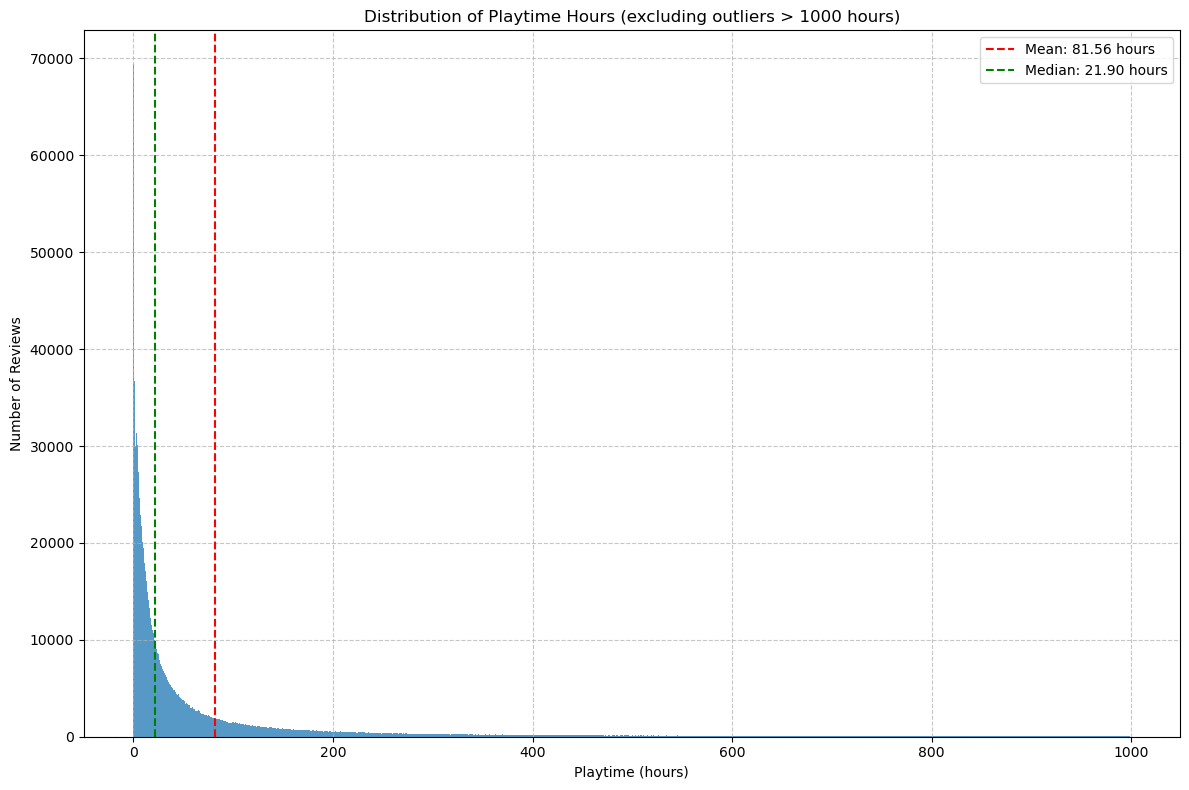

In [7]:
print("Generating playtime histogram...")

# For large datasets, sample to avoid memory issues
estimated_size = df.shape[0].compute()

if estimated_size > 1_000_000:
    # Use a sampling fraction that gives us at most 1M records
    sample_frac = min(1_000_000 / estimated_size, 1.0)
    print(f"Sampling {sample_frac:.2%} of data for histogram ({estimated_size:,} records)")
    playtime_data = df['playtime_hours'].sample(frac=sample_frac).compute()
else:
    # For smaller datasets, use all data
    playtime_data = df['playtime_hours'].compute()

# Filter outliers for better visualization (keep playtimes under 1000 hours)
filtered_playtime = playtime_data[playtime_data < 1000]

# Create histogram with 1-hour bins
plt.figure(figsize=(12, 8))
plt.hist(filtered_playtime, bins=np.arange(0, 1000, 1), alpha=0.75)
plt.title('Distribution of Playtime Hours (excluding outliers > 1000 hours)')
plt.xlabel('Playtime (hours)')
plt.ylabel('Number of Reviews')
plt.grid(True, linestyle='--', alpha=0.7)

# Add vertical lines for key statistics
global_mean = filtered_playtime.mean()
global_median = filtered_playtime.median()

plt.axvline(global_mean, color='r', linestyle='--', label=f'Mean: {global_mean:.2f} hours')
plt.axvline(global_median, color='g', linestyle='--', label=f'Median: {global_median:.2f} hours')

plt.legend()
plt.tight_layout()

# Save the histogram
plt.savefig('playtime_hist.png', dpi=300)
print("Histogram saved as 'playtime_hist.png'")

# Display the plot in the notebook
plt.show()